<a href="https://colab.research.google.com/github/manujsinghwal/23andMe-data-analysis/blob/main/23andMe_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 23andMe Data Analysis

In [2]:
# Mounting Google drive as dataset stored in a drive directory
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Data Exploration
Before diving into the questions, let's apply some data exploration techniques to have a better understanding of what we are dealing with in the dataset. We'll start with importing a few useful libraries. We will use pandas to create and analyse the dataset, and matplotlib.pyplot to do plot graphs to visualize our answers. Glob will be used just to get all filenames under the /data directory.

In [27]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
from scipy import stats

Let's create our dataset. First, we need to get all filenames under the **23andMe** directory in a list so we can concatenate them in one dataset using the pandas concat function which can accept a list as input. This method prevents us to use a for loop to iterate over files, read them separately and append to a dataset.

In [4]:
# Getting all filenames under the data directory
l = [pd.read_csv(filename) for filename in glob.glob("gdrive/My Drive/Colab Notebooks/Dataset/23andMe/*.csv")]

# Checking the list size to understand how many we read using above statement
len(l)

50

We have 50 files in our dataset, hence it's matching with the number of total files. Now, let's concatnate the data from these files and get everthing in a single DataFrame.

In [5]:
# Creating the DataFrame using all files under the data directory
df = pd.concat(l, axis = 0)
df.head()

,sale_time,purchaser_gender
0,2012-11-05 01:03:52,female
1,2012-11-05 01:17:49,female
2,2012-11-05 01:37:42,female
3,2012-11-05 01:43:03,female
4,2012-11-05 01:54:20,female


In [6]:
df.columns

Index(['sale_time', 'purchaser_gender'], dtype='object')

In [7]:
df.shape

(204329, 2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 204329 entries, 0 to 3408
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   sale_time         204329 non-null  object
 1   purchaser_gender  204329 non-null  object
dtypes: object(2)
memory usage: 4.7+ MB


In [41]:
# Assigning a constant figure size and use it in plotting to make plots larger
fig_size = (10, 5)

### Question 1
**Plot daily sales for all 50 weeks.**

In [20]:
df['sale_day'] = pd.to_datetime(df['sale_time']).dt.date

# Grouping data by date
sales = (
    df
    .groupby('sale_day')['purchaser_gender']
    .count()
    .reset_index(name='n_sales')
)

sales.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sale_day  350 non-null    object
 1   n_sales   350 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.6+ KB


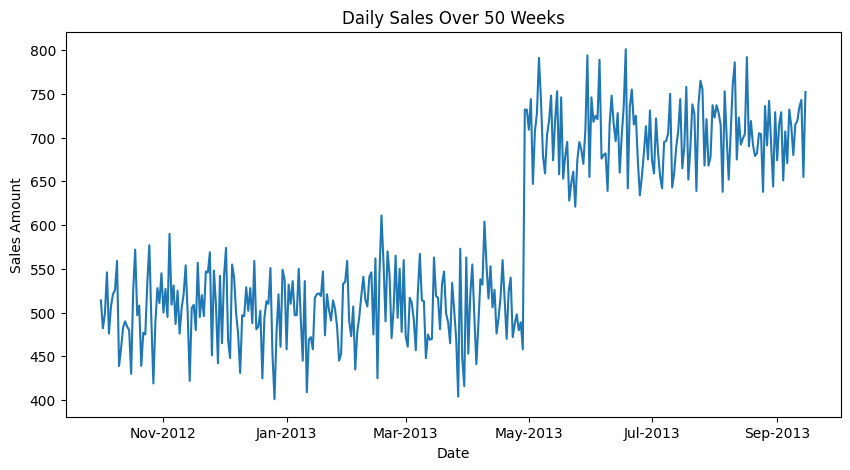

In [67]:
sales['sale_day'] = pd.to_datetime(sales['sale_day'])

# Plotting
plt.figure(figsize=fig_size)
plt.plot(sales['sale_day'], sales['n_sales'], linestyle='-', color='#1f77b4')

# Adding titles and labels
plt.title('Daily Sales Over 50 Weeks')
plt.xlabel('Date')
plt.ylabel('Sales Amount')

# Formatting the x-axis to show dates in mmm-yyyy format
date_format = mdates.DateFormatter('%b-%Y')
plt.gca().xaxis.set_major_formatter(date_format)

# Display the plot
plt.show()

### Question 2
**It looks like there has been a sudden change in daily sales. What date did it occur?**
\
To find out the sudden change in daily sales data, we can calculate the absolute sales difference from previous day and then find out the maximum difference.

In [12]:
# Calculating the absolute difference between today's and previous day sale
sales['difference'] = abs(sales['n_sales'].diff())

# Finding out the biggest difference
sudden_change = (
    sales
    .query('difference == difference.max()')
    .reset_index(drop=True)
    )

sudden_change

,sale_day,n_sales,difference
0,2013-04-29,732,274.0


### Question 3
**Is the change in daily sales at the date you selected statistically significant? If so, what is the p-value?**
\
We can use a one-sample t-test to compare the daily sales to a specific value (732 in this case). This test checks if the sales amount is significantly different from 732.

In [13]:
# Comparing the max change with all sales_amount column to understand its statistical importance
stats.ttest_1samp(sales['n_sales'], 732)

TtestResult(statistic=-26.367553024439697, pvalue=4.5681432390066193e-85, df=349)

**Interpretation:**
\
**P-value Explanation:** The p-value tells us the probability that the observed data (or something more extreme) would occur if the null hypothesis were true. In this context, the null hypothesis is that the sales amount is 732.
\
**Threshold:** Commonly, a threshold (alpha) of 0.05 is used to determine statistical significance. If the p-value is less than this threshold, we reject the null hypothesis.
\
\
**Conclusion:**
\
Since the p-value (1.3019593251472396e-84) is much smaller than 0.05, we reject the null hypothesis.
This means there is a statistically significant difference between the daily sales and the value 732.
Therefore, the change in daily sales on the selected date is significant and not due to random chance.

### Question 4
**Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers? Please use plots to support your answer (a rigorous statistical analysis is not necessary).**

In [46]:
df_proportion = (
    df
    .groupby(['sale_day','purchaser_gender'])
    .count()
    .reset_index()
    .rename(columns={'sale_time':'n_sales'})
)

df_proportion_male = (
    df_proportion
    .query('purchaser_gender == "male"')[['sale_day','n_sales']]
    .rename(columns={'n_sales':'n_sales_male'})
)

df_proportion_female = (
    df_proportion
    .query('purchaser_gender == "female"')[['sale_day','n_sales']]
    .rename(columns={'n_sales':'n_sales_female'})
)

proportion = pd.merge(
    df_proportion_male,
    df_proportion_female,
    on='sale_day'
)

proportion['male_to_female_ratio'] = proportion['n_sales_male']/proportion['n_sales_female']
proportion

,sale_day,n_sales_male,n_sales_female,male_to_female_ratio
0,2012-10-01,101,413,0.244552
1,2012-10-02,103,379,0.271768
2,2012-10-03,113,386,0.292746
3,2012-10-04,114,432,0.263889
4,2012-10-05,108,368,0.293478
...,...,...,...,...
345,2013-09-11,495,224,2.209821
346,2013-09-12,510,225,2.266667
347,2013-09-13,537,206,2.606796
348,2013-09-14,462,193,2.393782


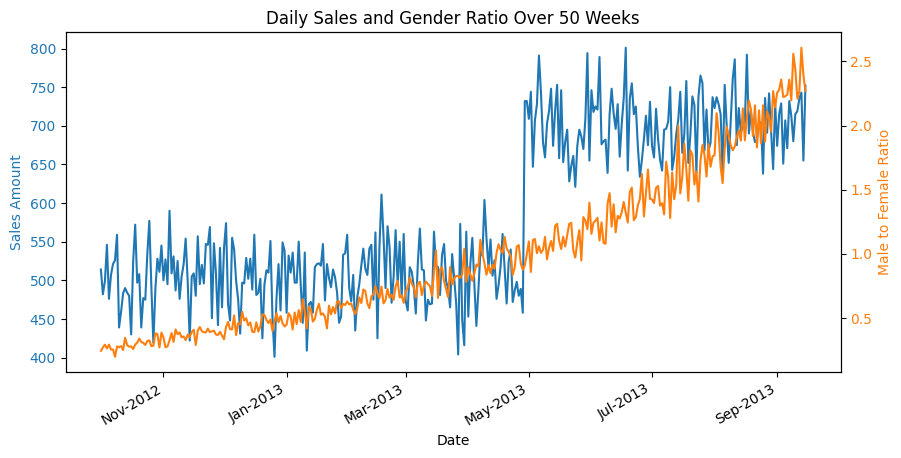

In [47]:
proportion['sale_day'] = pd.to_datetime(proportion['sale_day'])

# Plotting
fig, ax1 = plt.subplots(figsize=fig_size)

# Plot sales on the first y-axis
color = '#1f77b4'
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales Amount', color=color)
ax1.plot(sales['sale_day'], sales['n_sales'], linestyle='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Formatting the x-axis to show dates in mmm-yyyy format
date_format = mdates.DateFormatter('%b-%Y')
ax1.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

# Creating a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot gender ratio on the second y-axis
color = '#ff7f0e'
ax2.set_ylabel('Male to Female Ratio', color=color)
ax2.plot(proportion['sale_day'], proportion['male_to_female_ratio'], linestyle='-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Adding titles
plt.title('Daily Sales and Gender Ratio Over 50 Weeks')

# Display the plot
plt.show()

The increasing trend of the male vs female ratio in the sales amount does not explain the sudden change. The reason should be something different. For example, it might be caused by starting a new marketing campaign or adding a new feature to the website.

### Question 5
**Assume a given day is divided into four dayparts: night (12:00AM - 6:00AM), morning (6:00AM to 12:00PM), afternoon (12:00PM to 6:00PM) and evening (6:00PM - 12:00AM). What is the percentage of sales in each daypart over all 50 weeks?**

In [61]:
# Extracting the hour from sale_time
df['hour'] = df['sale_time'].dt.hour

# Defining the bins and labels for the dayparts
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']

# Use pd.cut to bin the hour into dayparts
df['dayparts'] = pd.cut(df['hour'], bins=bins, labels=labels, right=False, include_lowest=True)
df

,sale_time,purchaser_gender,sale_day,dayparts,hour
0,2012-11-05 01:03:52,female,2012-11-05,Night,1
1,2012-11-05 01:17:49,female,2012-11-05,Night,1
2,2012-11-05 01:37:42,female,2012-11-05,Night,1
3,2012-11-05 01:43:03,female,2012-11-05,Night,1
4,2012-11-05 01:54:20,female,2012-11-05,Night,1
...,...,...,...,...,...
3404,2012-12-23 22:57:10,female,2012-12-23,Evening,22
3405,2012-12-23 23:01:21,female,2012-12-23,Evening,23
3406,2012-12-23 23:31:34,female,2012-12-23,Evening,23
3407,2012-12-23 23:34:27,male,2012-12-23,Evening,23


In [68]:
daypart_sales = (
    df
    .groupby('dayparts')['purchaser_gender']
    .count()
    .reset_index(name='n_sales')
)

daypart_sales['sales_percentage'] = round(daypart_sales['n_sales'] * 100.0 / df.shape[0], 2)
daypart_sales.sort_values(by='sales_percentage', ascending=False)

,dayparts,n_sales,sales_percentage
2,Afternoon,80533,39.41
1,Morning,62870,30.77
3,Evening,42620,20.86
0,Night,18306,8.96
